# Code for BB84  protocol

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import os
import dataclasses
import sys
from copy import copy
from qcrypto.simbasics import *
import numba

In [6]:
getattr?

Docstring:
getattr(object, name[, default]) -> value

Get a named attribute from an object; getattr(x, 'y') is equivalent to x.y.
When a default argument is given, it is returned when the attribute doesn't
exist; without it, an exception is raised in that case.
Type:      builtin_function_or_method

In [2]:
def BB84(numqubits, numcheckbits, eve=False):
    # Alice initializations
    Alice = Agent(priv_qbittype="unentangled", num_priv_qubits=numqubits)
    Alice_base_choice = np.random.choice([1, 0], size=(numqubits))
    Alice_key = []

    for qubit_idx in range(numqubits):
        if Alice_base_choice[qubit_idx] == 1: # If 1, apply H gate and measure
            Alice.priv_qstates.apply_gate(H_gate, qubit_idx=qubit_idx)
            Alice_key.append(Alice.measure("private", qubit_idx=qubit_idx))
            Alice.priv_qstates.apply_gate(H_gate, qubit_idx=qubit_idx) # Re-apply gate to return to comp basis
        else: # If 0 just measure
            Alice_key.append(Alice.measure("private", qubit_idx=qubit_idx)) 
    Alice_key = np.array(Alice_key)
    
    Bob = Agent(priv_qstates=copy(Alice.priv_qstates))
    Bob_base_choice = np.random.choice([1, 0], size=(numqubits))
    Bob_key = []

    for qubit_idx in range(numqubits):
        if Bob_base_choice[qubit_idx] == 1:
            Bob.priv_qstates.apply_gate(H_gate, qubit_idx=qubit_idx)
            Bob_key.append(Bob.measure("private", qubit_idx=qubit_idx))
            Bob.priv_qstates.apply_gate(H_gate, qubit_idx=qubit_idx)
        else:
            Bob_key.append(Bob.measure("private", qubit_idx=qubit_idx))
    Bob_key = np.array(Bob_key)

    Alice_Bob_base_check = Alice_base_choice == Bob_base_choice
    Alice_key = Alice_key[Alice_Bob_base_check]
    Bob_key = Bob_key[Alice_Bob_base_check]

    Alice_check = Alice_key[:numcheckbits]
    Bob_check = Bob_key[:numcheckbits]

    discovered = not (Alice_check == Bob_check).all()

    Alice_key = Alice_key[numcheckbits:]
    Bob_key = Bob_key[numcheckbits:]

    return discovered, (Alice_key, Bob_key)

In [3]:
discovered, (Alice_key, Bob_key) = BB84(100_000, 200, eve=False)
print(discovered)
print(Alice_key)
print(Bob_key)

False
[0 1 1 ... 0 1 0]
[0 1 1 ... 0 1 0]


In [4]:
numqubits = 50
nchecks_lst = np.arange(numqubits//2)
probs = [] 
numtrials = 1000

def run_trial(nchecks, eve_present=True):
    if eve_present:
        detected, _ = BB84(numqubits, nchecks, eve=True)
    else:
        detected, _ = BB84(numqubits, nchecks, eve=False)
    return detected

for nchecks in nchecks_lst:
    temp = 0
    for _ in range(numtrials):
        detected = run_trial(nchecks, numqubits)
        if detected: temp += 1
    prob = temp / numtrials
    probs.append(prob)   

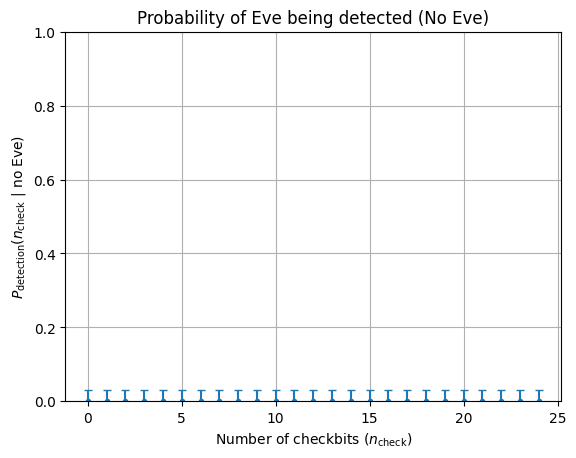

In [5]:
plt.scatter(nchecks_lst, probs, s=0.01)
plt.xlabel(r"Number of checkbits ($n_{\mathrm{check}}$)")
plt.ylabel(r"$P_{\mathrm{detection}}(n_{\mathrm{check}}\ |\ \mathrm{no\;Eve})$")
plt.title(r"Probability of Eve being detected (No Eve)")
plt.ylim(0, 1)
plt.errorbar(y=probs, x=nchecks_lst, yerr=[1/np.sqrt(numtrials)]*len(probs), fmt=".", capsize=3)
plt.grid()
plt.show()